In [56]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import speckleret

import torch
import speckleret as spr
import speckleret.torch as tspr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


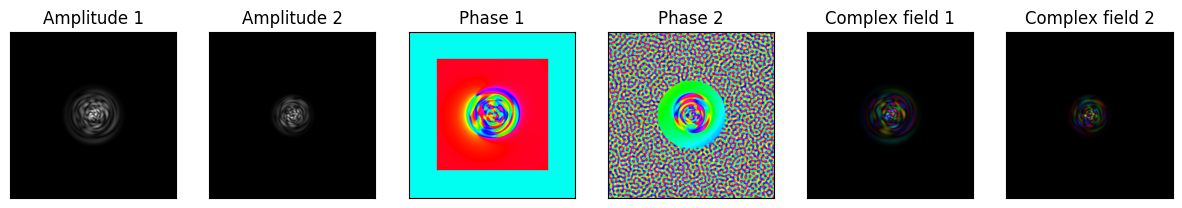

In [57]:
field = np.load('../imports/grin_speckle_example.npy')
field = speckleret.transforms.pad_img(field, pad=0.5)
ft = speckleret.transforms.fourier_transform(field, pad=None)

field = torch.from_numpy(field).to(torch.cfloat)
ft = torch.from_numpy(ft).to(torch.cfloat)

_ = speckleret.plots.compare_complex_fields(field.numpy(), ft.numpy(), remove_ticks=True)

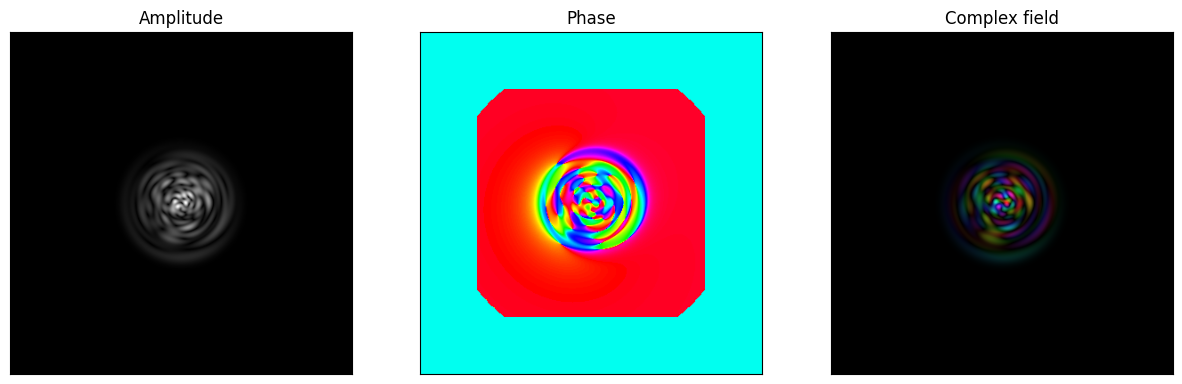

In [117]:
tfield = field.unsqueeze(0).unsqueeze(0)
tft = ft.unsqueeze(0).unsqueeze(0)

support = tspr.supports.threshold_support(tfield, threshold=0.00)
# support = tspr.supports.disk_support(field, radius=65)
supported_field = field * support


_ = speckleret.plots.complex_imshow(torch.squeeze(supported_field).numpy(), remove_ticks=True)

Iteration 0, Loss: 0.4289863109588623
Iteration 10, Loss: 0.11630439758300781
Iteration 20, Loss: 0.06188124418258667
Iteration 30, Loss: 0.044349849224090576
Iteration 40, Loss: 0.03714299201965332
Iteration 50, Loss: 0.033254265785217285
Iteration 60, Loss: 0.03082495927810669
Iteration 70, Loss: 0.028906702995300293
Iteration 80, Loss: 0.0277707576751709
Iteration 90, Loss: 0.027115046977996826
Iteration 100, Loss: 0.026630103588104248
Iteration 110, Loss: 0.02599179744720459
Iteration 120, Loss: 0.02571690082550049
Iteration 130, Loss: 0.025605320930480957
Iteration 140, Loss: 0.025286853313446045
Iteration 150, Loss: 0.025159895420074463
Iteration 160, Loss: 0.02505505084991455
Iteration 170, Loss: 0.024909019470214844
Iteration 180, Loss: 0.02489691972732544
Iteration 190, Loss: 0.02474212646484375
Iteration 200, Loss: 0.024618327617645264
Iteration 210, Loss: 0.024526119232177734
Iteration 220, Loss: 0.024422407150268555
Iteration 230, Loss: 0.024415969848632812
Iteration 240, L

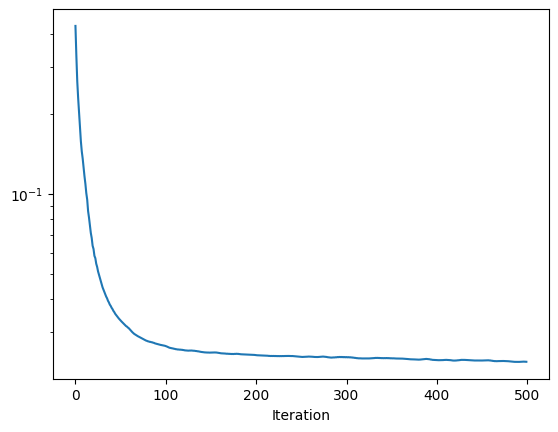

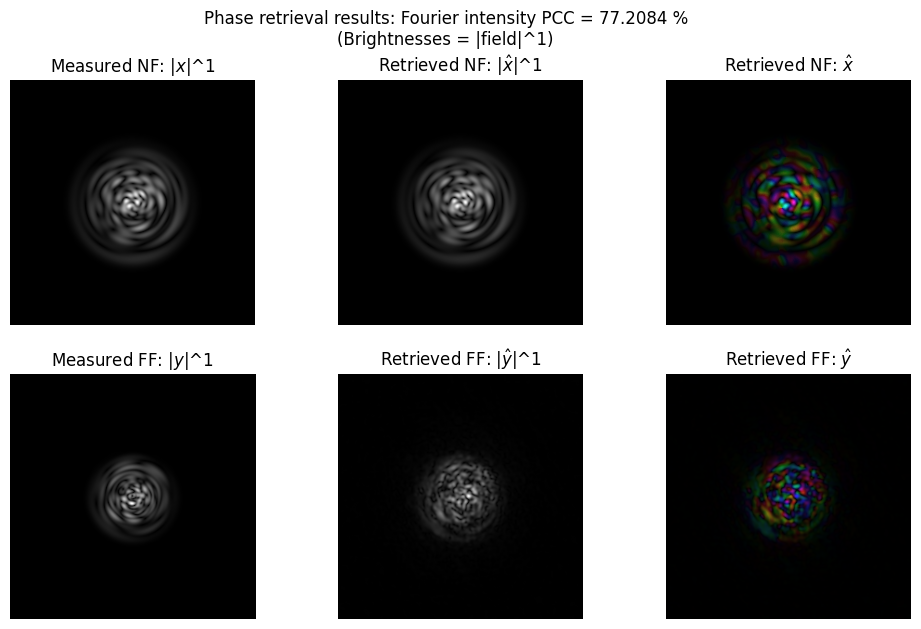

In [135]:
import torch.optim as optim


device = 'cuda'

tfield = tfield.to(device)
tft = tft.to(device)
support = support.to(device)



if device.startswith("cuda"):
    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

results = []


x, loss = tspr.initializers.gradient_descent(
        magnitude_near_field=torch.abs(tfield),
        magnitude_far_field=torch.abs(tft),
        support=support,
        optimizer_class=torch.optim.RMSprop,
        optimizer_kwargs=dict(lr=1e-1),
        max_iter=500,
        return_loss=True,
)


end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)
print(f"Total time: {elapsed_time_ms/1000:.4f} seconds")


plt.figure()
plt.plot(loss)
plt.yscale('log')
plt.xlabel('Iteration')



x_hat = x
y_hat = tspr.transforms.fourier_transform(x_hat)


hfig = spr.retrievalmath.show_retrieved_fields(
    tfield.cpu().detach().squeeze().numpy(), 
    tft.cpu().detach().squeeze().numpy(),
    x_hat.cpu().detach().squeeze().numpy(),
    y_hat.cpu().detach().squeeze().numpy(),
    power=1,
    window_crop=60,
)